In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt

In [2]:
import os
import argparse
import yaml
import wandb
import random
import time

import numpy as np
import torch
import torch.nn as nn

from data.dataset import SegmentDataset
from data.transforms import transform
from data.collate import collate
from torch.utils.data import DataLoader
from models.model import SegmentModel
from models.utils.loss import PixelLoss
from metrics.metrics import pixelAccuracy, gatherMetrics
from metrics.pred import predict, getMask
from utils.vis import showPredictions
from utils.decorators import timer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
version = 'v13'
cfg_path = '../configs/{}.yml'.format(version)
all_configs = yaml.safe_load(open(cfg_path))

random_seed = int(all_configs['random_seed'])
batch_size = int(all_configs['batch_size'])
num_classes = int(all_configs['num_classes'])
n_epoch = int(all_configs['n_epoch'])
train_annot = all_configs['train_annot']
val_annot = all_configs['val_annot']
n_segment_layers = all_configs['n_segment_layers']
optimizer = all_configs['optimizer']
lr = float(all_configs['lr'])
weight_decay = float(all_configs['weight_decay'])
adam_eps = float(all_configs['adam_eps'])
amsgrad = all_configs['amsgrad']
CHCEKPOINT_DIR = all_configs['CHCEKPOINT_DIR']
ckpt_dir = os.path.join(CHCEKPOINT_DIR, version)
use_augmentation = all_configs['use_augmentation']
loss_weights = None
if 'loss_weights' in all_configs:
    loss_weights = torch.FloatTensor(all_configs['loss_weights'])


In [4]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [5]:
model = SegmentModel(num_features=3, n_layers=n_segment_layers).cuda()
criterion = PixelLoss(num_classes=num_classes, loss_weights=loss_weights)

if optimizer=='adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, eps=adam_eps, amsgrad=amsgrad)

scheduler = None
if 'scheduler' in all_configs:
    train_losses, val_losses = [], []
    sch_factor = all_configs['scheduler']
    lr_lambda = lambda epoch: sch_factor**epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [6]:
train_set = SegmentDataset(annot='../'+train_annot, transform=transform, dim=(2048, 2048))
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=8,
    collate_fn=collate,
)
val_set = SegmentDataset(annot='../'+val_annot, transform=transform, dim=(2048, 2048))
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    num_workers=8,
    collate_fn=collate,
)

n_batch = 2
pred_fig_indices = list(range(0, len(val_loader)-1))
random.shuffle(pred_fig_indices)
pred_fig_indices = pred_fig_indices[:n_batch]

In [9]:
@timer
def train(epoch, loader, optimizer, metrics=[]):

    n = len(loader)
    tot_loss = 0.0
    masks, mask_preds = [], []
    y_preds = []
    if 'pred' in metrics:
        vis_img, vis_mask, vis_y_pred = [], [], []

    model.train()
    for batch_idx, (_, _, image, mask) in enumerate(loader):
        y_pred = model(image.cuda())
        image = image.detach().cpu()
        loss = criterion(y_pred, mask.cuda())
        loss.backward()
        optimizer.step()

        y_pred = y_pred.detach().cpu()
        tot_loss += loss.item()

        train_losses.append(loss.item())
        y_preds.append(y_pred)
        masks.append(mask)

        if 'pred' in metrics:
            if batch_idx in pred_fig_indices:
                vis_img.append(image)
                vis_mask.append(mask)
                vis_y_pred.append(y_pred)

        n_arr = (50*(batch_idx+1))//n
        progress = 'Training : [{}>{}] ({}/{}) loss : {:.4f}, avg_loss : {:.4f}'.format(
            '='*n_arr, '-'*(50-n_arr), (batch_idx+1), n, loss.item(), tot_loss/(batch_idx+1))
        print(progress, end='\r')

    print("\n")
    logg = {
        'training_loss': tot_loss/n,
    }

    # Metrics
    masks = torch.cat(masks, dim=0)
    y_preds = torch.cat(y_preds, dim=0)
    logg_metrics = gatherMetrics(
        params=(masks, y_preds),
        metrics=metrics,
        mode='train',
        debug=True,
    )
    logg.update(logg_metrics)

    # Visualizations
    if 'pred' in metrics:
        vis_img = torch.cat(vis_img, dim=0)
        vis_mask = torch.cat(vis_mask, dim=0)
        vis_y_pred = torch.cat(vis_y_pred, dim=0)
        vis_mask_pred = predict(None, None, use_cache=True, params=(vis_y_pred, False))
        pred_fig = showPredictions(
            vis_img, vis_mask, vis_mask_pred, 
            use_path=False, ret='fig', debug=False, size='auto',
            getMatch=True,
        )
        logg.update({'train_prediction': pred_fig})

    logg.update({'preds': y_preds, 'masks': masks})
    return logg


In [10]:
logg = train(1, train_loader, optimizer, metrics=['acc', 'conf', 'pred'])

Training : [==================================================>] (18/18) loss : 1.0755, avg_loss : 1.0899

Time : 52.37085437774658 seconds


In [11]:
logg.keys()

dict_keys(['training_loss', 'train_acc', 'train_conf', 'train_prediction', 'preds', 'masks'])

In [12]:
print(logg['training_loss'])
print(logg['train_acc'])

1.0898752742343478
0.3963170051574707


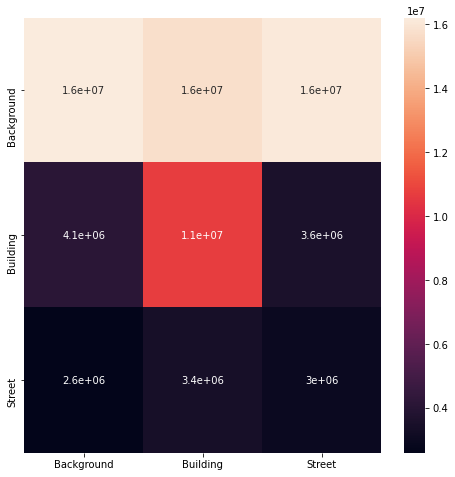

In [13]:
logg['train_conf']

In [35]:
preds, masks = logg['preds'], logg['masks']
masks_pred = predict(None, None, use_cache=True, params=(preds, False))

In [44]:
from utils.parameters import index2name, color2index

# print("1e5 order\n")
# print("{}\t\t\t{}\t\t{}\n".format('Class', 'GT', 'Pred'))
# for index, name in index2name.items():
#     print("{}\t\t{}\t\t{}".format(name, np.count_nonzero(masks==index)//1e5, np.count_nonzero(masks_pred==index)//1e5))

# print(type(masks==0), type(masks_pred==0))
print(np.count_nonzero((masks==0) & (masks_pred==0)))
print(np.count_nonzero((masks==0) & (masks_pred==1)))
print(np.count_nonzero((masks==0) & (masks_pred==2)))
print("\n")

print(np.count_nonzero((masks==1) & (masks_pred==0)))
print(np.count_nonzero((masks==1) & (masks_pred==1)))
print(np.count_nonzero((masks==1) & (masks_pred==2)))
print("\n")

print(np.count_nonzero((masks==2) & (masks_pred==0)))
print(np.count_nonzero((masks==2) & (masks_pred==1)))
print(np.count_nonzero((masks==2) & (masks_pred==2)))
print("\n")

16205175
15742581
16103832


4108228
10713855
3609122


2604485
3408292
3001902




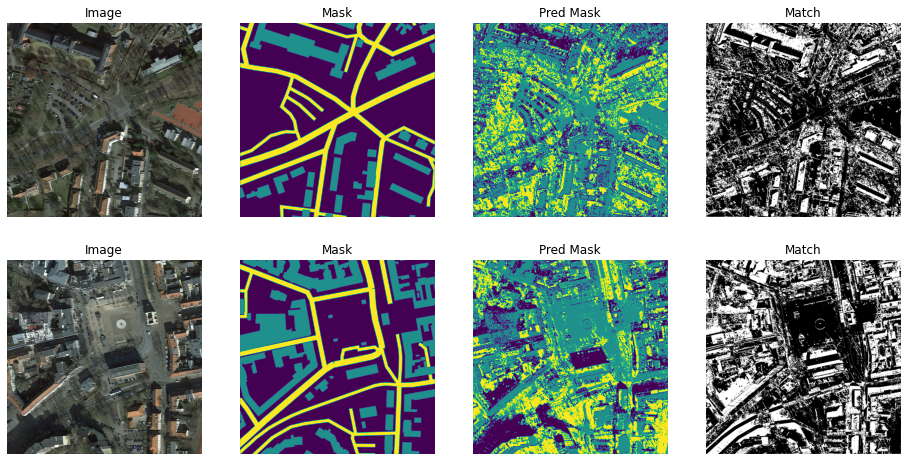

In [14]:
logg['train_prediction']

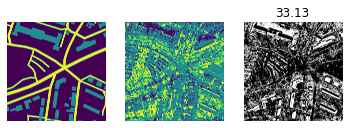

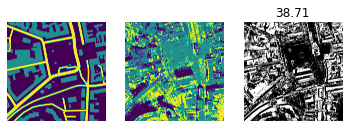

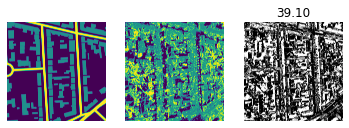

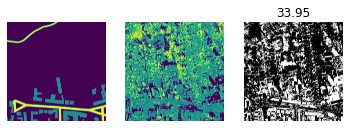

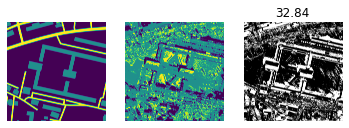

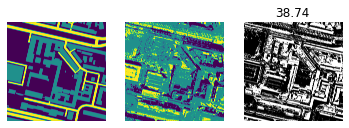

In [23]:
from utils.vis import showImageMask

for idx, (mask, pred) in enumerate(zip(masks, masks_pred)):
    fig, ax = plt.subplots(1, 3)
    match = mask==pred
#     print(np.count_nonzero(match), np.prod(match.shape)-np.count_nonzero(match))
#     mask, pred, match = mask[:100, :100], pred[:100, :100], match[:100, :100]
#     print(np.count_nonzero(match), np.prod(match.shape)-np.count_nonzero(match))
    for i, img in enumerate([mask, pred, match]):
        if i==2:
            ax[i].imshow(img, cmap=plt.cm.gray)
            n = np.prod(img.shape)
            n_match = np.count_nonzero(img)
            ax[i].set_title('{:.2f}'.format(n_match/n*100))
        else:
            ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()
    
    if idx==5:
        break

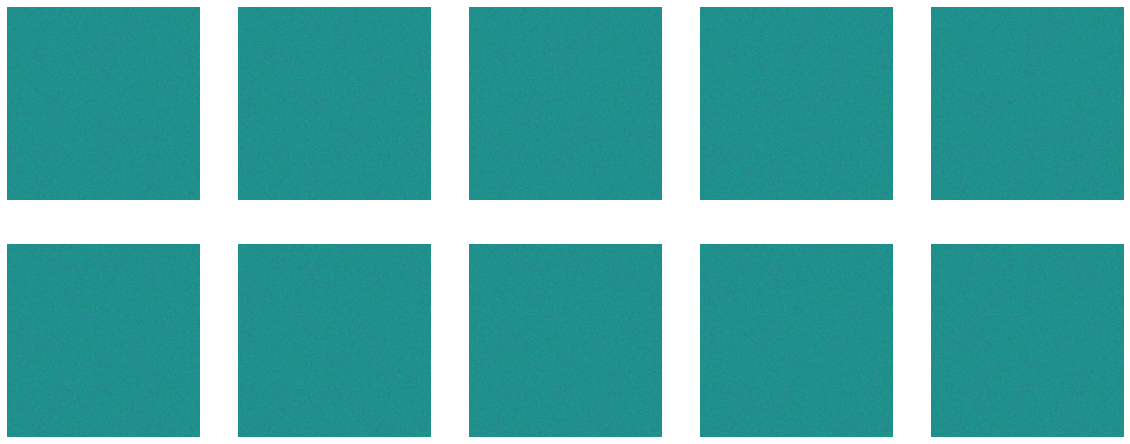

In [31]:
img1 = np.random.rand(2048, 2048)
# img2, img3, img4 = img1.copy(), img1.copy(), img1.copy()


r, c = 2, 5
fig, ax = plt.subplots(r, c, figsize=(4*c, 4*r))
for i in range(r):
    for j in range(c):
        ax[i, j].imshow(img1)
        ax[i, j].axis('off')
plt.show()